In [1]:
import numpy as np
from numba import njit, prange
import pandas as pd
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from scipy.stats import gaussian_kde, norm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial, Gaussian
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegressionCV

## ROCKET FUNCTIONS

# @njit("Tuple((float64[:],int32[:],float64[:],int32[:],int32[:]))(int64,int64)")
@njit("Tuple((float64[:],int32[:],float64[:],int32[:],int32[:]))(int64,int64,int32[:])")
def generate_kernelss(input_length, num_kernels,kernel_len):
    #7,9,11
    # candidate_lengths = np.array((20,20,20), dtype = np.int32)
    candidate_lengths=kernel_len
    lengths = np.random.choice(candidate_lengths, num_kernels)

    weights = np.zeros(lengths.sum(), dtype = np.float64)
    biases = np.zeros(num_kernels, dtype = np.float64)
    dilations = np.zeros(num_kernels, dtype = np.int32)
    paddings = np.zeros(num_kernels, dtype = np.int32)

    a1 = 0

    for i in range(num_kernels):

        _length = lengths[i]

        _weights = np.random.normal(0, 1, _length)

        b1 = a1 + _length
        weights[a1:b1] = _weights - _weights.mean()

        biases[i] = np.random.uniform(-1, 1)

        # dilation = 2 ** np.random.uniform(0, np.log2((input_length - 1) / (_length - 1))) if _length != input_length else 1
        dilation = 2 ** np.random.uniform(0, np.log2(max((input_length - 1) / (_length - 1), 1))) if _length != input_length else 1

        # dilation = 2 ** np.random.uniform(0, np.log2((input_length - 1) / (_length - 1)))
        dilation = np.int32(dilation)
        dilations[i] = dilation

        padding = ((_length - 1) * dilation) // 2 if np.random.randint(2) == 1 else 0
        paddings[i] = padding

        a1 = b1

    return weights, lengths, biases, dilations, paddings

@njit(fastmath = True)
def apply_kernel(X, weights, length, bias, dilation, padding):

    input_length = len(X)

    output_length = (input_length + (2 * padding)) - ((length - 1) * dilation)

    _ppv = 0
    # _max = np.NINF

    end = (input_length + padding) - ((length - 1) * dilation)

    for i in range(-padding, end):

        _sum = bias

        index = i

        for j in range(length):

            if index > -1 and index < input_length:

                _sum = _sum + weights[j] * X[index]

            index = index + dilation

        # if _sum > _max:
        #     _max = _sum

        if _sum > 0:
            _ppv += 1
# , _max
    return _ppv / output_length

@njit("float64[:,:](float64[:,:],Tuple((float64[::1],int32[:],float64[:],int32[:],int32[:])))", parallel = True, fastmath = True)
def apply_kernels(X, kernels):

    weights, lengths, biases, dilations, paddings = kernels

    num_examples, _ = X.shape
    num_kernels = len(lengths)

    _X = np.zeros((num_examples, num_kernels * 1), dtype = np.float64) # 2 features per kernel

    for i in prange(num_examples):

        a1 = 0 # for weights
        a2 = 0 # for features

        for j in range(num_kernels):

            b1 = a1 + lengths[j]
            b2 = a2 + 2

            _X[i, a2:b2] = \
            apply_kernel(X[i], weights[a1:b1], lengths[j], biases[j], dilations[j], paddings[j])

            a1 = b1
            a2 = b2

    return _X

# Normalize the data
def normalize_data(X):
    mean = X.mean(axis=-1, keepdims=True)
    std = X.std(axis=-1, keepdims=True) + 1e-8
    return (X - mean) / std



OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:

# Load training data
training_data = np.loadtxt("kernel_size_exploration/UWaveGestureLibraryAll/UWaveGestureLibraryAll_TRAIN.txt")
Y_training, X_training = training_data[:, 0].astype(np.int32), training_data[:, 1:]
test_data = np.loadtxt("kernel_size_exploration/UWaveGestureLibraryAll/UWaveGestureLibraryAll_TEST.txt")
Y_test, X_test = test_data[:, 0].astype(np.int32), test_data[:, 1:]
kernels = generate_kernelss(X_training.shape[-1], 100,np.array((7, 9, 11), dtype=np.int32))
X_training_transform = apply_kernels(X_training, kernels)
X_test_transform = apply_kernels(X_test, kernels)


In [51]:
np.shape(X_training_transform)

(896, 100)

In [8]:
X_test_transform

array([[0.12044199, 0.12044199, 0.35630252, ..., 0.94920635, 0.73650794,
        0.73650794],
       [0.25303867, 0.25303867, 0.32941176, ..., 0.86031746, 0.53227513,
        0.53227513],
       [0.19558011, 0.19558011, 0.30084034, ..., 0.86243386, 0.63492063,
        0.63492063],
       ...,
       [0.12928177, 0.12928177, 0.4789916 , ..., 0.95978836, 0.55449735,
        0.55449735],
       [0.27292818, 0.27292818, 0.53445378, ..., 0.8021164 , 0.51216931,
        0.51216931],
       [0.07955801, 0.07955801, 0.35798319, ..., 0.96084656, 0.77142857,
        0.77142857]])

In [182]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde

def local_mfdr(fit, X=None, y=None, method='kernel'):
    if not hasattr(fit, 'coef_'):
        raise ValueError('fit must be a model object from scikit-learn')

    if X is None or y is None:
        raise ValueError("This procedure requires X and y. Please provide X and y data.")

    if X.ndim != 2:
        raise ValueError("X must be a two-dimensional array")

    # Standardize X
    XX = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    n, p = XX.shape
    
    # Coefficients and intercept
    coef = fit.coef_.ravel()
    intercept = fit.intercept_[0]  # Assuming intercept is a scalar

    # Calculate probabilities, residuals, and z-scores
    probabilities = fit.predict_proba(X)[:, 1]
    U = y - probabilities
    W = np.diag(probabilities * (1 - probabilities))
    
    z_scores = np.zeros(p)
    for j in range(p):
        v_j = XX[:, j].T @ W @ XX[:, j]
        z_scores[j] = (XX[:, j].T @ U + v_j * coef[j]) / np.sqrt(v_j)
    # z_scores = (probabilities - y) / np.sqrt(probabilities * (1 - probabilities) / 100)
    
    if method == 'kernel':
        # Use Gaussian KDE for density estimation
        density = gaussian_kde(z_scores)
        x_d = np.linspace(min(z_scores), max(z_scores), 1000)
        y_d = density(x_d)
        
        # Creating an interpolation function, adjusting extrapolation limits to prevent unrealistic high density values
        density_interp = interp1d(x_d, y_d, bounds_error=False, fill_value=(y_d[0], y_d[-1]), kind='linear')
        normal_pdf_values = norm.pdf(z_scores)
        density_values = density_interp(z_scores)
        est_gam =(normal_pdf_values / density_values).astype(np.float64)
    

    # Prepare results DataFrame
    results = pd.DataFrame({
        'z': z_scores,  # Insert zero for intercept z-score
        'mfdr': est_gam  # Assuming full certainty for intercept's local FDR
    })


    return results

# Example usage:
# model = LogisticRegression(max_iter=1000)
# model.fit(X_training_transform, Y_training)
# results = local_mfdr(model, X=X_training_transform, y=Y_training)
# print(results.head())


In [183]:
classifier = LogisticRegression(max_iter=1000, penalty="l2").fit(X_training_transform, Y_training)
df=local_mfdr(classifier,X=X_training_transform,y=Y_training)

In [184]:
df


,z,mfdr
0,-48.331431,0.000000e+00
1,-48.331431,0.000000e+00
2,54.906739,0.000000e+00
3,54.906739,0.000000e+00
4,-22.474435,1.283456e-108
...,...,...
95,-67.773911,0.000000e+00
96,47.765553,0.000000e+00
97,47.765553,0.000000e+00
98,53.416344,0.000000e+00


2024-05-02 00:11:24.144 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED _fit distribution (taking more than 30 seconds)
2024-05-02 00:11:24.220 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted anglit distribution with error=207.000041)
2024-05-02 00:11:24.313 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted arcsine distribution with error=245.321178)
2024-05-02 00:11:24.334 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted bradford distribution with error=222.692399)
2024-05-02 00:11:24.371 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=206.384335)
2024-05-02 00:11:24.626 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted argus distribution with error=210.111886)
2024-05-02 00:11:24.659 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted alpha distribution with error=211.84909)
2024-05-02 00:11:24.674 | INFO     | fitter.fitter:_fit_single_distribut

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gausshyper,205.203133,15.337761,30.968782,inf,0.069668,0.690249
gengamma,205.209523,16.998911,27.419592,inf,0.069578,0.691763
exponweib,205.224348,16.703131,27.123812,inf,0.069757,0.688761
genhalflogistic,205.342180,9.466968,17.282479,inf,0.071914,0.652365
mielke,205.355573,19.338342,29.759023,inf,0.069493,0.693199


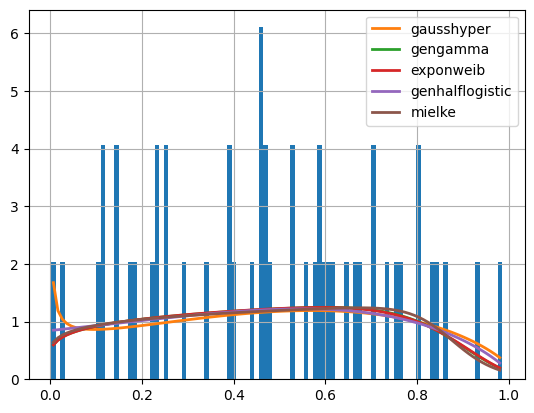

/Applications/anaconda3/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  
/Applications/anaconda3/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  


In [178]:
from fitter import Fitter
data = X_training_transform[0]
f = Fitter(data)
f.fit()
# may take some time since by default, all distributions are tried
# but you call manually provide a smaller set of distributions
f.summary()
# # Create histogram
# plt.hist(data, bins=100, color='blue', alpha=0.7, rwidth=0.85)

# # Add labels and title
# plt.xlabel('Values')
# plt.ylabel('Frequency')
# plt.title('Histogram of X_training_transform[0]')

# # Show plot
# plt.grid(axis='y', alpha=0.75)
# plt.show()

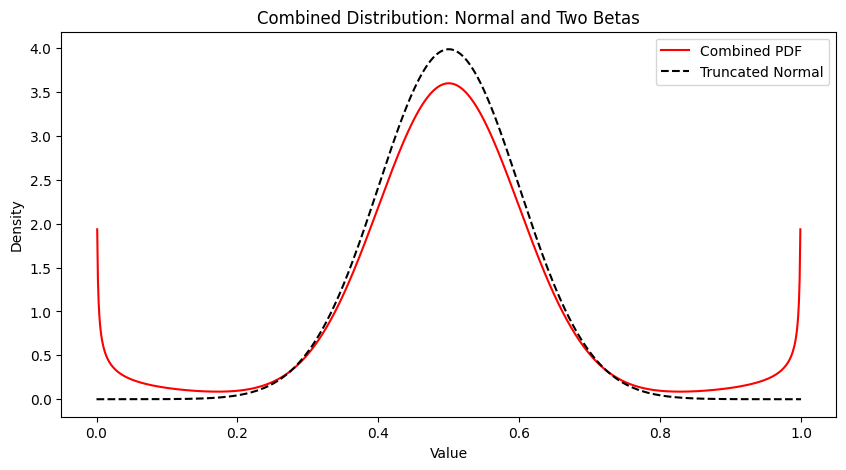

In [175]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, truncnorm, norm


alpha1, beta1 = 0.5, 5      
alpha2, beta2 = 5, 0.5 
mu, sigma = 0.5, 0.1       # Mean and standard deviation for the normal distribution


weights = [0.05, 0.05, 0.9]  


lower, upper = 0, 1
a, b = (lower - mu) / sigma, (upper - mu) / sigma
trunc_normal = truncnorm(a, b, loc=mu, scale=sigma)


x = np.linspace(0, 1, 1000)


pdf_beta1 = beta.pdf(x, alpha1, beta1)
pdf_beta2 = beta.pdf(x, alpha2, beta2)
pdf_normal = trunc_normal.pdf(x)


combined_pdf = weights[0] * pdf_beta1 + weights[1] * pdf_beta2 + weights[2] * pdf_normal

# Plot the result
plt.figure(figsize=(10, 5))
plt.plot(x, combined_pdf, 'r-', label='Combined PDF')
# plt.plot(x, pdf_beta1, 'b--', label='Beta 1')
# plt.plot(x, pdf_beta2, 'g--', label='Beta 2')
plt.plot(x, pdf_normal, 'k--', label='Truncated Normal')
plt.title('Combined Distribution: Normal and Two Betas')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()
